# Install

In [ ]:
!pip install datasets transformers seqeval evaluate
!pip install pandas scikit-learn

# Import Library

In [ ]:
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)
import evaluate
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import os
from transformers import EarlyStoppingCallback

# Config

In [ ]:
MODEL_NAME = "indolem/indobert-base-uncased"
TRAIN_FILE = "/content/train.txt"
VALID_FILE = "/content/val.txt"
OUTPUT_DIR = "/content/drive/MyDrive/deep_learning"

BATCH_SIZE = 8
EPOCHS = 10
LR = 5e-5
MAX_LENGTH = 128
SEED = 42

set_seed(SEED)

# Dataset

## Load Dataset

In [ ]:
def read_data(path: str):
    sentences, labels = [], []
    cur_tokens, cur_labels = [], []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()

            if line == "":
                if cur_tokens:
                    sentences.append(cur_tokens)
                    labels.append(cur_labels)
                    cur_tokens, cur_labels = [], []
                continue

            if "\t" in line:
                tok, lab = line.split("\t")
            else:
                tok, lab = line.split(maxsplit=1)

            cur_tokens.append(tok)
            cur_labels.append(lab)

    if cur_tokens:
        sentences.append(cur_tokens)
        labels.append(cur_labels)

    return sentences, labels


train_sents, train_labels = read_data(TRAIN_FILE)
val_sents, val_labels = read_data(VALID_FILE)

print("Train sentences:", len(train_sents))
print("Val sentences:", len(val_sents))

Train sentences: 999
Val sentences: 111


## Label Mapping

In [ ]:
train_label_set = sorted({l for seq in train_labels for l in seq})
val_label_set   = sorted({l for seq in val_labels for l in seq})

print("Label di TRAIN:", train_label_set)
print("Label di VALID:", val_label_set)

Label di TRAIN: ['B-$$$', 'B-ADJ', 'B-ADK', 'B-ADV', 'B-ART', 'B-CCN', 'B-CSN', 'B-INT', 'B-KUA', 'B-NEG', 'B-NNO', 'B-NNP', 'B-NUM', 'B-PAR', 'B-PPO', 'B-PRI', 'B-PRK', 'B-PRN', 'B-PRR', 'B-SYM', 'B-UNS', 'B-VBI', 'B-VBL', 'B-VBP', 'B-VBT']
Label di VALID: ['B-$$$', 'B-ADJ', 'B-ADK', 'B-ADV', 'B-ART', 'B-CCN', 'B-CSN', 'B-INT', 'B-KUA', 'B-NEG', 'B-NNO', 'B-NNP', 'B-NUM', 'B-PAR', 'B-PPO', 'B-PRI', 'B-PRK', 'B-PRN', 'B-PRR', 'B-SYM', 'B-UNS', 'B-VBI', 'B-VBL', 'B-VBP', 'B-VBT']


In [ ]:
all_labels = sorted(set(train_label_set) | set(val_label_set))

label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

label_list = all_labels

num_labels = len(all_labels)

print("Jumlah label:", num_labels)
print("Label mapping:")
print(label2id)

Jumlah label: 25
Label mapping:
{'B-$$$': 0, 'B-ADJ': 1, 'B-ADK': 2, 'B-ADV': 3, 'B-ART': 4, 'B-CCN': 5, 'B-CSN': 6, 'B-INT': 7, 'B-KUA': 8, 'B-NEG': 9, 'B-NNO': 10, 'B-NNP': 11, 'B-NUM': 12, 'B-PAR': 13, 'B-PPO': 14, 'B-PRI': 15, 'B-PRK': 16, 'B-PRN': 17, 'B-PRR': 18, 'B-SYM': 19, 'B-UNS': 20, 'B-VBI': 21, 'B-VBL': 22, 'B-VBP': 23, 'B-VBT': 24}


## Build HuggingFace Dataset

In [ ]:
train_data = [{"tokens": t, "tags": [label2id[l] for l in labs]}
              for t, labs in zip(train_sents, train_labels)]

val_data   = [{"tokens": t, "tags": [label2id[l] for l in labs]}
              for t, labs in zip(val_sents, val_labels)]

train_ds = Dataset.from_list(train_data)
val_ds   = Dataset.from_list(val_data)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Tokenize and Align Labels

In [ ]:
def tokenize_and_align(examples):
    tokenized = tokenizer(examples["tokens"], is_split_into_words=True,
                          truncation=True, max_length=MAX_LENGTH)

    labels_out = []
    for i, labs in enumerate(examples["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        prev = None
        temp = []

        for w in word_ids:
            if w is None:
                temp.append(-100)
            elif w != prev:
                temp.append(labs[w])
            else:
                temp.append(-100)
            prev = w

        labels_out.append(temp)

    tokenized["labels"] = labels_out
    return tokenized

train_ds = train_ds.map(tokenize_and_align, batched=True, remove_columns=["tokens", "tags"])
val_ds   = val_ds.map(tokenize_and_align, batched=True, remove_columns=["tokens", "tags"])

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

# Model and Metrics

## Load Model

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

data_collator = DataCollatorForTokenClassification(tokenizer)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indolem/indobert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Metrics

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)

    y_true, y_pred = [], []

    for pred, lab in zip(preds, labels):
        true_single = []
        pred_single = []
        for p_i, l_i in zip(pred, lab):
            if l_i != -100:
                true_single.append(id2label[int(l_i)])
                pred_single.append(id2label[int(p_i)])
        y_true.append(true_single)
        y_pred.append(pred_single)

    # overall
    overall_precision = precision_score(y_true, y_pred)
    overall_recall = recall_score(y_true, y_pred)
    overall_f1 = f1_score(y_true, y_pred)

    # per-label
    report = classification_report(
        y_true, y_pred,
        output_dict=True,
        zero_division=0
    )

    results = {
        "overall_precision": overall_precision,
        "overall_recall": overall_recall,
        "overall_f1": overall_f1,
    }

    for lbl in label_list:
        if lbl in report:
            results[f"{lbl}_precision"] = report[lbl]["precision"]
            results[f"{lbl}_recall"] = report[lbl]["recall"]
            results[f"{lbl}_f1"] = report[lbl]["f1-score"]

    return results


# Training

## Training Arguments

In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=LR,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    logging_steps=50,
    report_to=[],
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    greater_is_better=True,
    seed=SEED
)

## Trainer and Train

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()
eval_result = trainer.evaluate()
eval_result

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Overall Precision,Overall Recall,Overall F1
1,1.829000,0.444892,0.863698,0.863698,0.863698
2,0.377300,0.271203,0.908224,0.908224,0.908224
3,0.206600,0.261622,0.915039,0.915039,0.915039
4,0.130800,0.263292,0.919582,0.919582,0.919582
5,0.078600,0.254844,0.925034,0.925034,0.925034
6,0.052400,0.299391,0.926397,0.926397,0.926397
7,0.029900,0.306750,0.928669,0.928669,0.928669
8,0.018500,0.325753,0.930486,0.930486,0.930486
9,0.012000,0.336306,0.934121,0.934121,0.934121
10,0.010300,0.334759,0.931849,0.931849,0.931849


{'eval_loss': 0.3363056480884552,
 'eval_overall_precision': 0.9341208541572013,
 'eval_overall_recall': 0.9341208541572013,
 'eval_overall_f1': 0.9341208541572013,
 'eval_runtime': 0.4658,
 'eval_samples_per_second': 238.297,
 'eval_steps_per_second': 30.055,
 'epoch': 10.0}

## Loss Train and Val

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

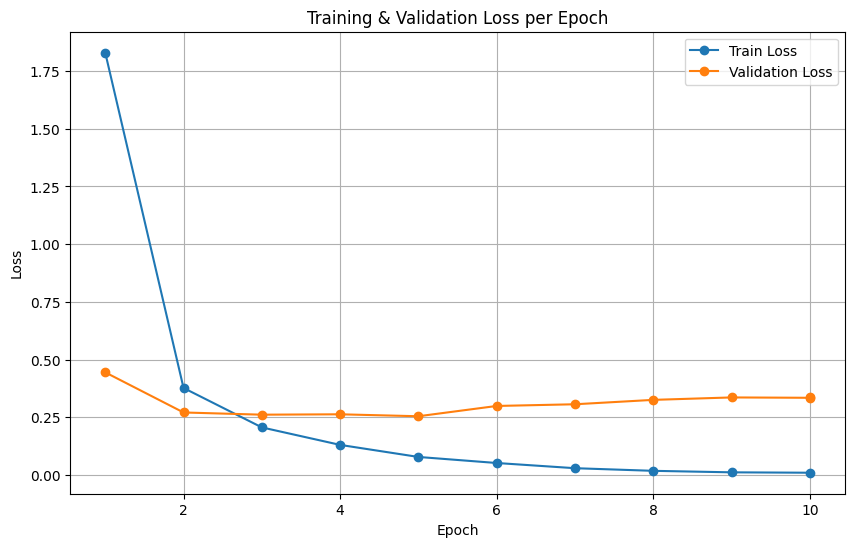

In [ ]:
train_loss = df_log[df_log["loss"].notna()][["epoch", "loss"]]
eval_loss  = df_log[df_log["eval_loss"].notna()][["epoch", "eval_loss"]]

plt.figure(figsize=(10,6))
plt.plot(train_loss["epoch"], train_loss["loss"], marker="o", label="Train Loss")
plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

## Training Arguments

In [ ]:
import torch
from transformers.training_args import TrainingArguments

torch.serialization.add_safe_globals([TrainingArguments])

args = torch.load(
    "/content/drive/MyDrive/deep_learning/checkpoint-625/training_args.bin",
    weights_only=False
)

print(args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False,

Note:  
**Hyperparameter Optimizer / Learning**
- learning_rate = 5e-5
- warmup_ratio = 0.1
- weight_decay = 0.01
- adam_beta1 = 0.9
- adam_beta2 = 0.999
- adam_epsilon = 1e-08
- lr_scheduler_type = cosine

**Hyperparameter Training Loop**
-  num_train_epochs = 10
- per_device_train_batch_size = 8
- per_device_eval_batch_size = 8
- gradient_accumulation_steps = 1

**Saving & Best Model**
- load_best_model_at_end = True
- metric_for_best_model = "overall_f1"
- save_strategy = "epoch"

**Tokenizer / Data**
- remove_unused_columns = True
- group_by_length = False

# Testing

In [ ]:
import numpy as np
from seqeval.metrics import classification_report

In [ ]:
TEST_FILE = "/content/test.txt"

test_sents, test_labels = read_data(TEST_FILE)
test_data = [
    {"tokens": t, "tags": [label2id[l] for l in labs]}
    for t, labs in zip(test_sents, test_labels)
]

test_ds = Dataset.from_list(test_data)

test_ds = test_ds.map(
    tokenize_and_align,
    batched=True,
    remove_columns=["tokens", "tags"]
)

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
predictions, labels, _ = trainer.predict(test_ds)

preds = np.argmax(predictions, axis=-1)
id2label = model.config.id2label

y_true, y_pred = [], []

for pred, lab in zip(preds, labels):
    true_single, pred_single = [], []
    for p_i, l_i in zip(pred, lab):
        if l_i != -100:
            true_single.append(id2label[int(l_i)])
            pred_single.append(id2label[int(p_i)])
    y_true.append(true_single)
    y_pred.append(pred_single)

print("\n=== PER LABEL PERFORMANCE ===")
print(classification_report(y_true, y_pred, digits=4))



=== PER LABEL PERFORMANCE ===
              precision    recall  f1-score   support

         $$$     1.0000    1.0000    1.0000         4
         ADJ     0.9753    0.9834    0.9794       362
         ADK     0.9421    0.9572    0.9496       187
         ADV     0.9606    0.9848    0.9726       198
         ART     0.5429    0.2405    0.3333        79
         CCN     0.9945    0.9890    0.9917       182
         CSN     1.0000    1.0000    1.0000        84
         INT     1.0000    1.0000    1.0000        47
         KUA     0.9180    0.9333    0.9256        60
         NEG     1.0000    1.0000    1.0000        61
         NNO     0.9947    0.9781    0.9863      1142
         NNP     0.9945    0.9890    0.9917       363
         NUM     0.9940    0.9709    0.9824       172
         PAR     1.0000    1.0000    1.0000        16
         PPO     0.9972    1.0000    0.9986       361
         PRI     1.0000    1.0000    1.0000        20
         PRK     1.0000    0.8710    0.9310       

## Confusion Matrix

In [ ]:
def get_confusion_matrix(trainer, dataset, label_list, id2label):
    preds = trainer.predict(dataset)

    predictions = np.argmax(preds.predictions, axis=2)
    true_labels, pred_labels = [], []

    for pred, lab in zip(predictions, preds.label_ids):
        for p_i, l_i in zip(pred, lab):
            if l_i != -100:  # ignore subword tokens
                true_labels.append(id2label[int(l_i)])
                pred_labels.append(id2label[int(p_i)])

    cm = confusion_matrix(true_labels, pred_labels, labels=label_list)
    df_cm = pd.DataFrame(cm, index=label_list, columns=label_list)
    return df_cm

In [ ]:
cm_test = get_confusion_matrix(
    trainer,
    test_ds,
    label_list=label_list,
    id2label=id2label
)

print(cm_test)

       B-$$$  B-ADJ  B-ADK  B-ADV  B-ART  B-CCN  B-CSN  B-INT  B-KUA  B-NEG  \
B-$$$      4      0      0      0      0      0      0      0      0      0   
B-ADJ      0    356      0      2      0      0      0      0      0      0   
B-ADK      0      0    179      5      0      0      0      0      0      0   
B-ADV      0      0      3    195      0      0      0      0      0      0   
B-ART      0      0      0      0     19      1      0      0      0      0   
B-CCN      0      0      2      0      0    180      0      0      0      0   
B-CSN      0      0      0      0      0      0     84      0      0      0   
B-INT      0      0      0      0      0      0      0     47      0      0   
B-KUA      0      1      0      1      2      0      0      0     56      0   
B-NEG      0      0      0      0      0      0      0      0      0     61   
B-NNO      0      4      0      0      0      0      0      0      0      0   
B-NNP      0      0      0      0      0      0     

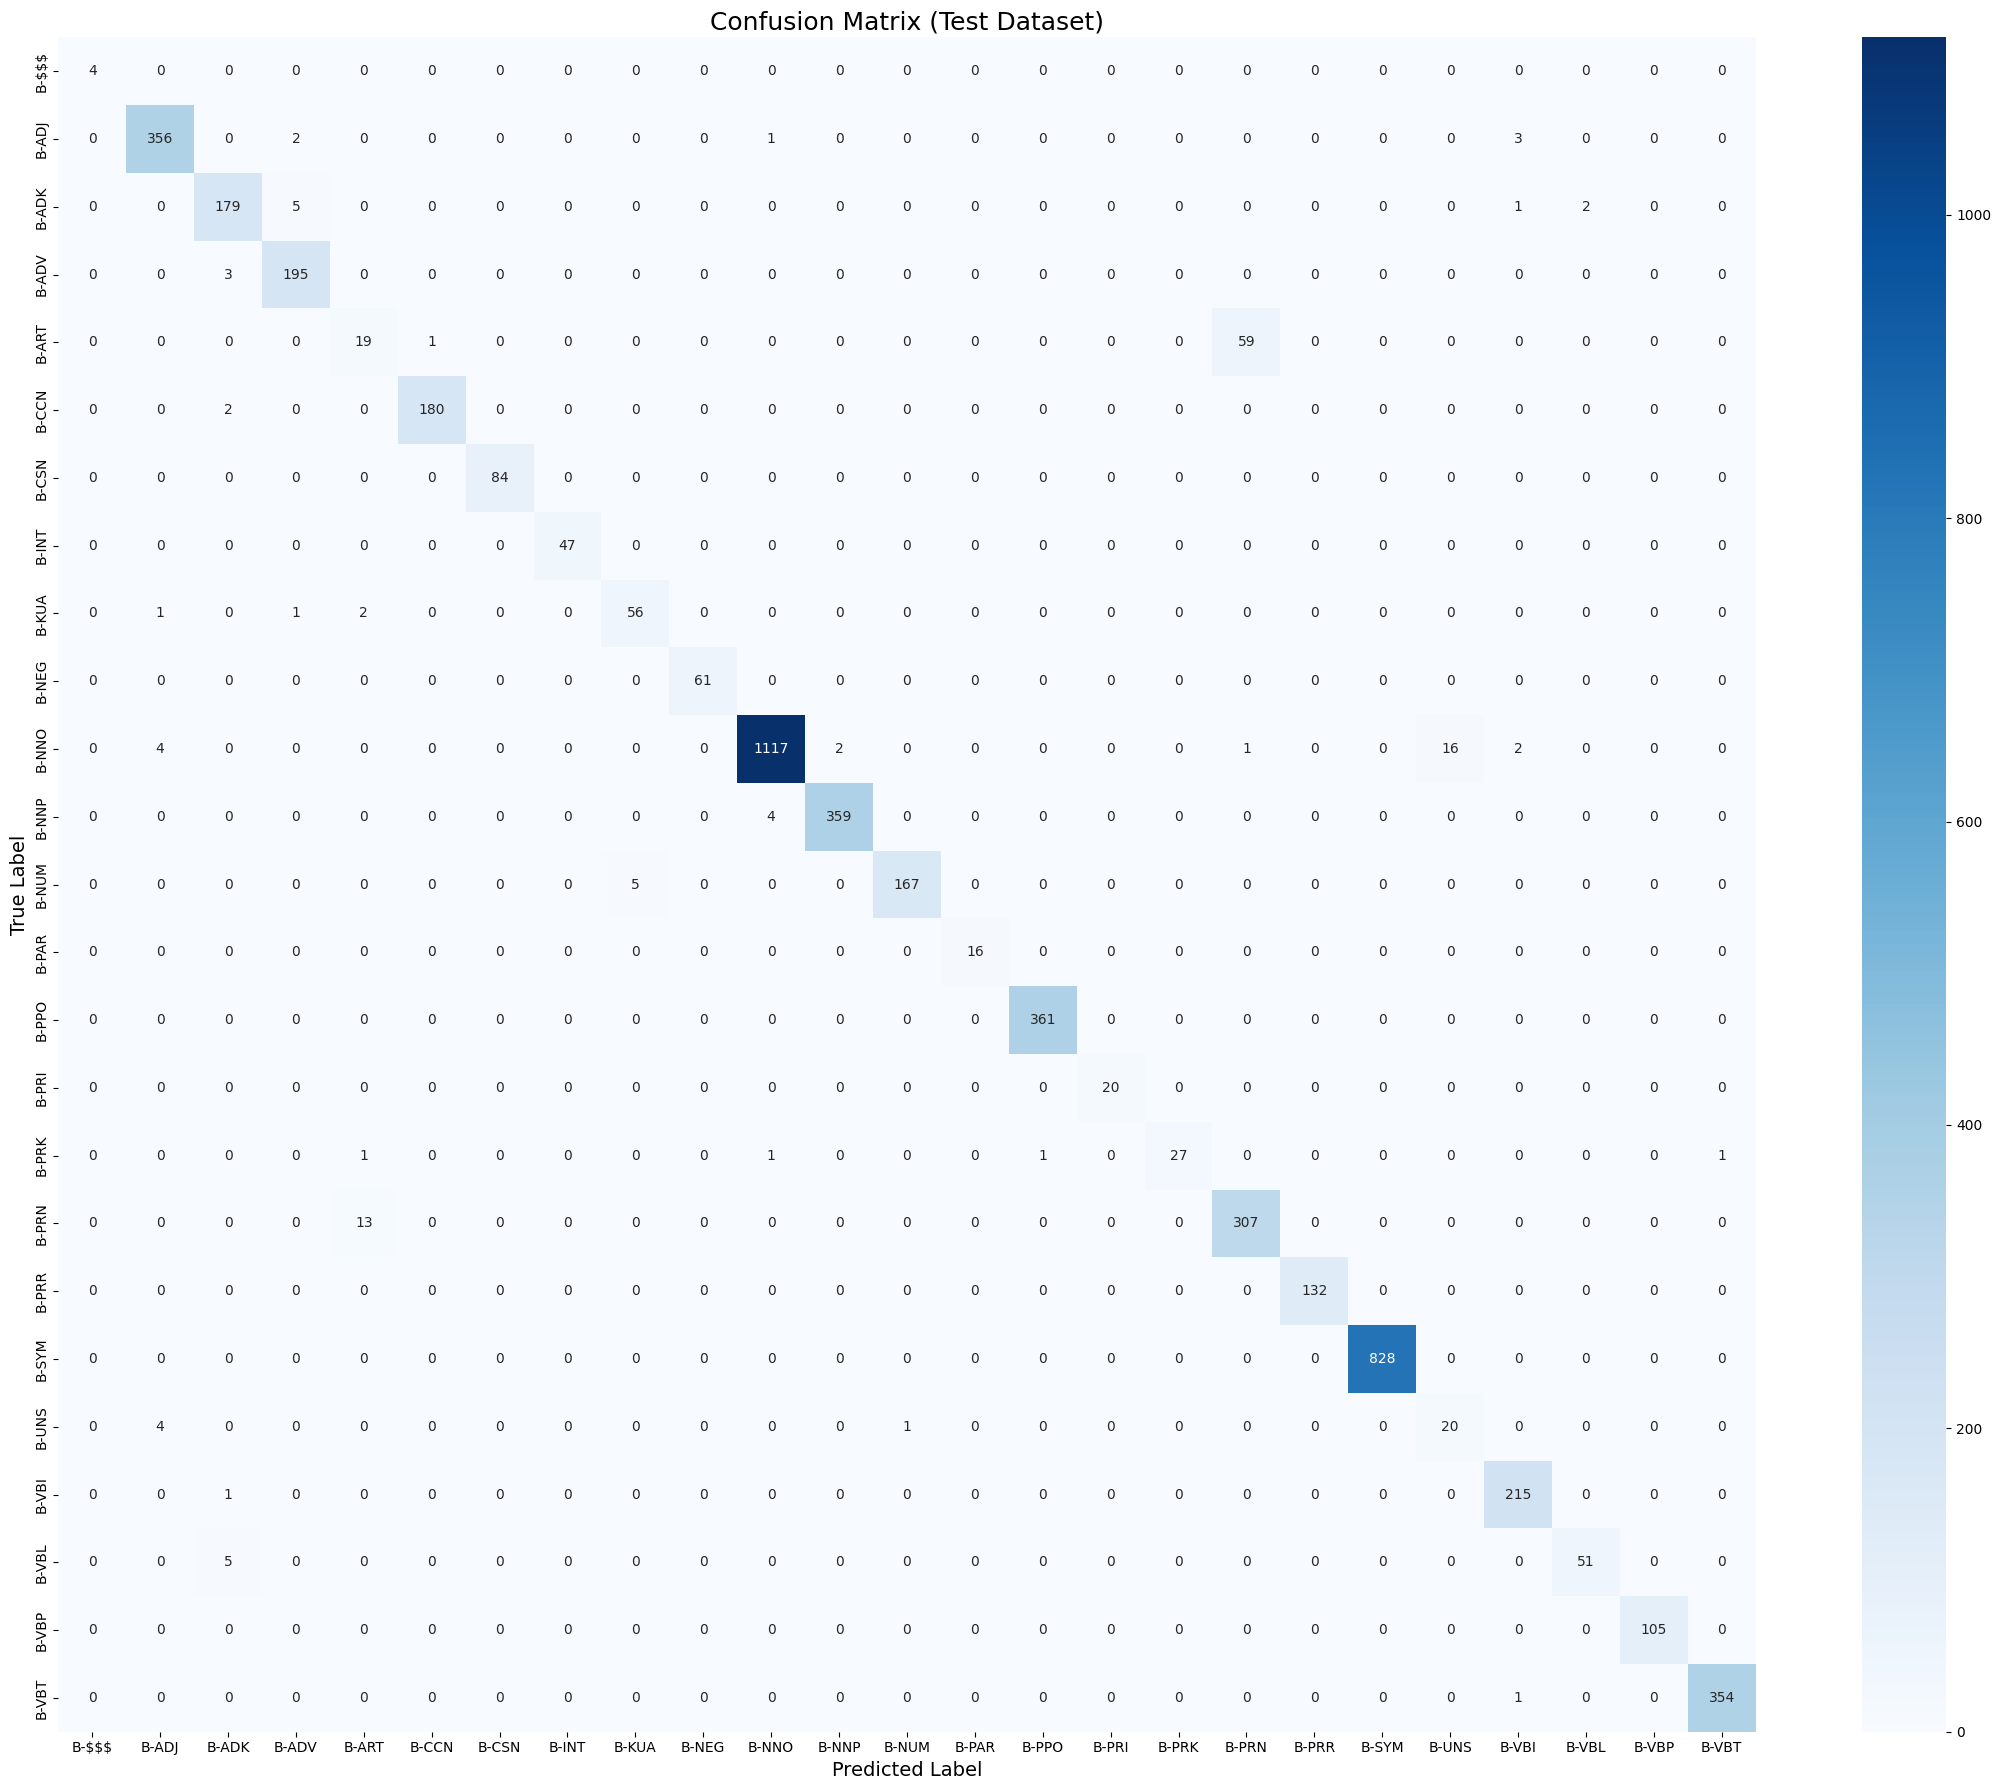

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22, 18))
sns.heatmap(
    cm_test,
    annot=True,
    cmap="Blues",
    fmt="d"
)

plt.title("Confusion Matrix (Test Dataset)", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()


# Inference

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForTokenClassification

MODEL_DIR = "/content/drive/MyDrive/deep_learning/checkpoint-625"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR)
model.eval()

def predict_pos(sentence):
    words = sentence.split()
    inputs = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt",
    )

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predictions = torch.argmax(probs, dim=2)

    id2label = model.config.id2label
    word_ids = inputs.word_ids(batch_index=0)

    predicted_labels = []
    predicted_confidence = []

    previous_word_idx = None

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            continue

        label_id = predictions[0][idx].item()
        label_name = id2label[label_id]
        confidence = probs[0][idx][label_id].item()

        predicted_labels.append(label_name)
        predicted_confidence.append(confidence)

        previous_word_idx = word_idx

    print("Hasil POS Tagging")
    for w, l, c in zip(words, predicted_labels, predicted_confidence):
        print(f"{w:15} -> {l:6} (confidence: {c:.4f})")


kalimat = "hari ini aku makan pisang goreng"
predict_pos(kalimat)

Hasil POS Tagging
hari            -> B-NNO  (confidence: 0.9975)
ini             -> B-PRN  (confidence: 0.5553)
aku             -> B-PRN  (confidence: 0.9990)
makan           -> B-VBT  (confidence: 0.9484)
pisang          -> B-NNP  (confidence: 0.9195)
goreng          -> B-VBI  (confidence: 0.8351)


# API

In [ ]:
!pip  install pyngrok

In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("2JPznioJj3MwkwXmcuYTo0cUkIQ_7yvMc9GzqYdzWJ627Jn4i")

In [ ]:
%%writefile api.py
import re
import torch
import torch.nn.functional as F
from fastapi import FastAPI
from transformers import AutoTokenizer, AutoModelForTokenClassification

app = FastAPI(title="POS Tagging API")

MODEL_DIR = "/content/drive/MyDrive/deep_learning/checkpoint-625"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR)
model.eval()

# tokenizer berbasis regex (kata, angka desimal, tanda baca)
def tokenize_words(sentence: str):
    return re.findall(r"\d+\.\d+|\w+|[^\w\s]", sentence)

def predict_pos(sentence: str):
    # tokenisasi linguistik
    words = tokenize_words(sentence)

    inputs = tokenizer(
        words,
        is_split_into_words=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**inputs)

    # softmax → probabilities
    probs = F.softmax(outputs.logits, dim=-1)
    predictions = torch.argmax(outputs.logits, dim=2)

    id2label = model.config.id2label
    word_ids = inputs.word_ids(batch_index=0)

    previous_word_idx = None
    results = []

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            continue

        label_id = predictions[0][idx].item()
        confidence = probs[0][idx][label_id].item()

        results.append({
            "word": words[word_idx],
            "label": id2label[label_id],
            "confidence": round(confidence, 4)
        })

        previous_word_idx = word_idx

    return results

@app.get("/")
def home():
    return {
        "message": "POS Tagging API is running",
        "usage": "/predict?sentence=input",
        "docs": "/docs"
    }

@app.get("/predict")
def predict(sentence: str):
    return {"result": predict_pos(sentence)}


Overwriting api.py


In [ ]:
import uvicorn
from threading import Thread

def run_api():
    uvicorn.run("api:app", host="0.0.0.0", port=8000)

In [ ]:
public_url = ngrok.connect(8000)
public_url

<NgrokTunnel: "https://d07576c9446f.ngrok-free.app" -> "http://localhost:8000">

In [ ]:
!uvicorn api:app --host 0.0.0.0 --port 8000 --reload

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [26669] using StatReload
2025-12-24 14:03:35.279088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766585015.334985   26689 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766585015.346283   26689 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766585015.375063   26689 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766585015.375111   26689 computation_placer.cc:17

INFO:     Started server process [26689]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     202.58.198.238:0 - "GET /predict?sentence=saya%20punya%20dua%20teman,%20namanya%20marsyani%20dan%20putri HTTP/1.1" 200 OK
INFO:     202.58.198.238:0 - "GET /predict?sentence=saya%20punya%20teman,%20namanya%20marsyani%20dan%20putri HTTP/1.1" 200 OK
